# RS Oph
RS Oph is a binary system that undergoes recurrent **nova** eruption every ~15 years. The last one was in August 2021 and was extensively followed up at gamma rays. RS Oph is the first nova detected at gamma rays above 100 GeV.

In this notebook, we will model its gamma-ray emission.

<img src="images/RSOph.png" alt="RSOph" width="600">

Credit: David A.Hardy / www.astroart.org & PPARC.

In [69]:
from astropy.table import Table
import astropy.units as u
import naima
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from IPython.display import Image
import matplotlib.animation as animation
import naima
from IPython.display import HTML
from astropy.visualization import quantity_support

# Display the SED

In [70]:
# Load the three tables
sed_day1 = Table.read('../data/RSOph/RSOph_day1_sed.ecsv', format='ascii.ecsv')
sed_day2 = Table.read('../data/RSOph/RSOph_day2_sed.ecsv', format='ascii.ecsv')
sed_day3 = Table.read('../data/RSOph/RSOph_day3_sed.ecsv',format='ascii.ecsv')
sed_day4 = Table.read('../data/RSOph/RSOph_day4_sed.ecsv', format='ascii.ecsv')

daily_data = [sed_day1, sed_day2, sed_day3, sed_day4]
days = [1, 2, 3, 4]

# Create figure
fig, ax = plt.subplots(figsize=(6, 4))

# Update function for animation
def update(frame):
    ax.clear()
    for i in np.unique(daily_data[frame]['group'].value):
        mask_group=daily_data[frame]['group'].value==i
        mask_ul=daily_data[frame]['ul'].value==True
        ax.errorbar(
            x=daily_data[frame]["energy"].value[mask_ul & mask_group], 
            y=daily_data[frame]["energy"].value[mask_ul & mask_group]**2*daily_data[frame]["flux"].value[mask_ul & mask_group],
            yerr=daily_data[frame]["energy"].value[mask_ul & mask_group]**2*daily_data[frame]["flux"].value[mask_ul & mask_group]*0.3,
            color=naima.plot.color_cycle[i],
            marker="o",ls="",uplims=True
        )
        ax.errorbar(
            x=daily_data[frame]["energy"].value[~mask_ul & mask_group], 
            y=daily_data[frame]["energy"].value[~mask_ul & mask_group]**2*daily_data[frame]["flux"].value[~mask_ul & mask_group],
            yerr=daily_data[frame]["energy"].value[~mask_ul & mask_group]**2*daily_data[frame]["flux_error"].value[~mask_ul & mask_group],
            color=naima.plot.color_cycle[i],
            marker="o",ls=""
        )

    ax.set_title(f"Day {days[frame]} after eruption")
    ax.set_xlim((0.00006, 2.6))
    ax.set_ylim((5e-14, 2e-08))
    ax.set_xlabel("Energy (TeV)")
    ax.set_ylabel(f"E$^2$ d$\phi$/dE (erg cm$^{{-2}}$ s$^{{-1}}$)")
    ax.set_xscale("log")
    ax.set_yscale("log")
    plt.tight_layout()
    plt.close()
ani = animation.FuncAnimation(fig, update, frames=len(daily_data), interval=1000, repeat=True);

# Save as GIF
# ani.save("data_animation.gif", writer="pillow", fps=1)

HTML(ani.to_jshtml())

The emission at gamma rays within the first four days after the eruption is variable!

- At GeV the emission decreases
- At TeV the emission increases

# Model fitting

Although a complex modellization would be required to model the temporal evolution of the particles and physical parameters of the system involved in the gamma-ray emission of RS Oph and account for the gamma-gamma absorption by the photons of the photosphere, below we will use a simple model with naima for this task.

Note that naima does not consider temporal evolution in the physical parameters. Therefore, we have to add it by hand. We will consider the parametrization in Acciari et al. 2022.

<img src="images/Schematic_model.png" alt="RSOph model" width="600">

Source: Acciari, V. A., Ansoldi, S., Antonelli, L. A., et al. 2022, Nature Astronomy, 6, 689

## Hadronic model 

Hadronic stands for a model that only accounts for processes involving handronds in the interactions to explain the gamma-ray emission. In this case, we will use the neutral pion decay radiative process.

Note that secondary particles, e.g. electrons, can also produce gamma rays! We will not consider this possibilty.

In [71]:
%%writefile RSOph_results/hadronic_model/RSOph_hadronic.py
# magic command to write the content of the cell to a file

#imports
import astropy.units as u
import numpy as np
import naima
from naima.models import ExponentialCutoffPowerLaw
from astropy.table import Table
import os

class PionDecayModel:
    """
    Define a model for the pion decay emission from a proton energy distribution
    following a power-law with exponential cut-off.
    
    A variable target proton density is parameterized as a function of the day
    after the nova explosion.
    """
    def __init__(self, day_value):
        self.day_value = day_value

    def PionDecay(self, pars, data):
        """
        Define particle distribution model, radiative model, and return model flux
        at data energy values
        """
        ECPL = ExponentialCutoffPowerLaw(
            10 ** pars[0] / u.eV, 130 * u.GeV, pars[1], 10 ** pars[2] * u.GeV
        )
        PP = naima.models.PionDecay(ECPL, nh=6.0e8*(self.day_value/3)**(-3) * u.cm ** -3)

        return PP.flux(data, distance=2.45 * u.kpc)

def lnprior(pars):
    # Limit amplitude to positive domain
    logprob = naima.uniform_prior(pars[0], 0, np.inf)
               
    return logprob


if __name__ == '__main__':

    sed_day1 = Table.read('../data/RSOph/RSOph_day1_sed.ecsv',format='ascii.ecsv')
    sed_day2 = Table.read('../data/RSOph/RSOph_day2_sed.ecsv',format='ascii.ecsv')
    sed_day3 = Table.read('../data/RSOph/RSOph_day3_sed.ecsv',format='ascii.ecsv')
    sed_day4 = Table.read('../data/RSOph/RSOph_day4_sed.ecsv',format='ascii.ecsv')

    daily_data = [sed_day1, sed_day2, sed_day3, sed_day4]

    # Set initial parameters and labels
    p0 = np.array((31, 2.5, np.log10(200)))
    labels = ["log10(norm)", "index", "log10(cutoff)"]
    day_array=[1,2,3,4]

    os.system("rm RSOph_results/hadronic_model/fit_naima_results_all*")

    for yy,iday in enumerate(day_array):
        
        p0 = np.array((31, 2.5, np.log10(200)))
        day_value=iday
        
        print("day",day_value)

        # Create the function with the correct day_value
        PionDecay_func = PionDecayModel(iday)
        
        # Run sampler    
        sampler, pos = naima.run_sampler(
            data_table=daily_data[yy],
            p0=p0,
            labels=labels,
            model=PionDecay_func.PionDecay,
            prior=lnprior,
            nwalkers=32,
            nburn=10,
            nrun=40,
            threads=4,
            prefit=True,
            interactive=False,
        )
        ## Save run results
        out_root = "RSOph_results/hadronic_model/fit_naima_results_all_day{}".format(day_array[yy])
        naima.save_run(out_root + ".hdf5", sampler)

        ## Save diagnostic plots and results table
        naima.save_diagnostic_plots(out_root, sampler, sed=True)
        naima.save_results_table(out_root, sampler) 
        print( )
        print( )

Overwriting RSOph_results/hadronic_model/RSOph_hadronic.py


Execute the script.

In [72]:
subprocess.run(["python","RSOph_results/hadronic_model/RSOph_hadronic.py"])

day 1
INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [31.00620822  2.5         2.30103   ] [naima.core]
INFO:    Initial lnprob(p0): -456.032 [naima.core]
INFO:    New ML parameters : [30.5511529   2.48024554  2.43099639] [naima.core]
INFO:    Maximum lnprob(p0): -8.249 [naima.core]
Burning in the 32 walkers with 10 steps...

Progress of the run: 0 percent (0 of 10 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      30.5            2.48            2.43      
  Last ensemble std    :      0.149          0.0133          0.0136     
  Last ensemble lnprob :  avg: -32.999, max: -8.254

Progress of the run: 10 percent (1 of 10 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      30.5            2.48            2.43      
  Last ensemble std    :      0.143          0.0156          0.0202     
  Last ensem

/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/site-packages/naima/analysis.py:163: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  f.clf()


INFO: Plotting Model output 1... [naima.analysis]
INFO: Saving results table in RSOph_results/hadronic_model/fit_naima_results_all_day1_results.ecsv [naima.analysis]


day 2
INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [31.84083014  2.5         2.30103   ] [naima.core]
INFO:    Initial lnprob(p0): -383.184 [naima.core]
INFO:    New ML parameters : [31.08574968  2.67210129  2.92234262] [naima.core]
INFO:    Maximum lnprob(p0): -11.265 [naima.core]
Burning in the 32 walkers with 10 steps...

Progress of the run: 0 percent (0 of 10 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      31.1            2.67            2.92      
  Last ensemble std    :      0.132          0.0115          0.0159     
  Last ensemble lnprob :  avg: -22.655, max: -11.302

Progress of the run: 10 percent (1 of 10 steps)
                           --log10(norm)-- -----index----- -log

/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/site-packages/naima/analysis.py:163: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  f.clf()


INFO: Plotting Model output 1... [naima.analysis]
INFO: Saving results table in RSOph_results/hadronic_model/fit_naima_results_all_day2_results.ecsv [naima.analysis]


day 3
INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [32.49634292  2.5         2.30103   ] [naima.core]
INFO:    Initial lnprob(p0): -1221.275 [naima.core]
INFO:    New ML parameters : [31.38817857  2.74059121  3.41215115] [naima.core]
INFO:    Maximum lnprob(p0): -11.672 [naima.core]
Burning in the 32 walkers with 10 steps...

Progress of the run: 0 percent (0 of 10 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      31.4            2.74            3.41      
  Last ensemble std    :      0.17           0.0102          0.0164     
  Last ensemble lnprob :  avg: -40.037, max: -11.688

Progress of the run: 10 percent (1 of 10 steps)
                           --log10(norm)-- -----index----- -lo

/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/site-packages/naima/analysis.py:163: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  f.clf()


INFO: Plotting Model output 1... [naima.analysis]
INFO: Saving results table in RSOph_results/hadronic_model/fit_naima_results_all_day3_results.ecsv [naima.analysis]


day 4
INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [32.60606247  2.5         2.30103   ] [naima.core]
INFO:    Initial lnprob(p0): -410.246 [naima.core]
INFO:    New ML parameters : [31.69687348  2.66990214  3.30657869] [naima.core]
INFO:    Maximum lnprob(p0): -13.252 [naima.core]
Burning in the 32 walkers with 10 steps...

Progress of the run: 0 percent (0 of 10 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      31.7            2.67            3.31      
  Last ensemble std    :      0.129          0.0136          0.0135     
  Last ensemble lnprob :  avg: -23.133, max: -13.270

Progress of the run: 10 percent (1 of 10 steps)
                           --log10(norm)-- -----index----- -log

/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/site-packages/naima/analysis.py:163: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  f.clf()
Exception ignored in: <function Pool.__del__ at 0x1379f8220>
Traceback (most recent call last):
  File "/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/multiprocessing/pool.py", line 271, in __del__
  File "/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/multiprocessing/queues.py", line 371, in put
AttributeError: 'NoneType' object has no attribute 'dumps'


INFO: Plotting Model output 1... [naima.analysis]
INFO: Saving results table in RSOph_results/hadronic_model/fit_naima_results_all_day4_results.ecsv [naima.analysis]




CompletedProcess(args=['python', 'RSOph_results/hadronic_model/RSOph_hadronic.py'], returncode=0)

### Check the results

The script has finished. Let's see the results...

In [73]:
# Load results
tabs_hadronic=[]
for day in [1,2,3,4]:
    tab=Table.read(f"RSOph_results/hadronic_model/fit_naima_results_all_day{day}_results.ecsv")
    tabs_hadronic.append(tab) 

Display the table with the best-fit parameter values

In [74]:
display(tabs_hadronic[0])

label,median,unc_lo,unc_hi
str13,float64,float64,float64
log10(norm),30.55148526608176,0.09010499105771075,0.09567847737174517
norm,3.560289111584416e+30,6.670769958106155e+29,8.774719509923245e+29
index,2.4794234350116717,0.0765537558005076,0.06119882053244563
log10(cutoff),2.428950556072014,0.09024747928651244,0.05908502099611246
cutoff,268.5038739720069,50.380057610903435,39.13102117312047
blob1,nan,nan,nan


In [75]:
runs_hardonic=[]
for day in [1,2,3,4]:
    file=f"RSOph_results/hadronic_model/fit_naima_results_all_day{day}.hdf5"
    run=naima.read_run(file, modelfn=None)
    runs_hardonic.append(run)
# naima.plot_corner(runs_hardonic[0]);
# naima.plot_chain(runs_hardonic[0],0);

#### Diagnostic plots

Check a given parameter

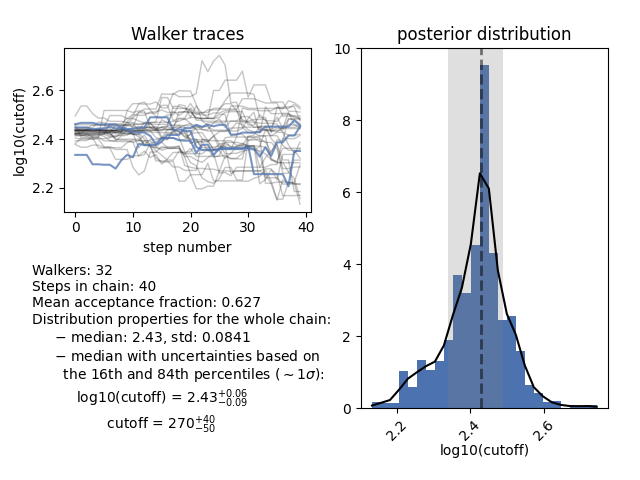

In [76]:
Image("RSOph_results/hadronic_model/fit_naima_results_all_day1_chain_cutoff.png")


Check the corner plot

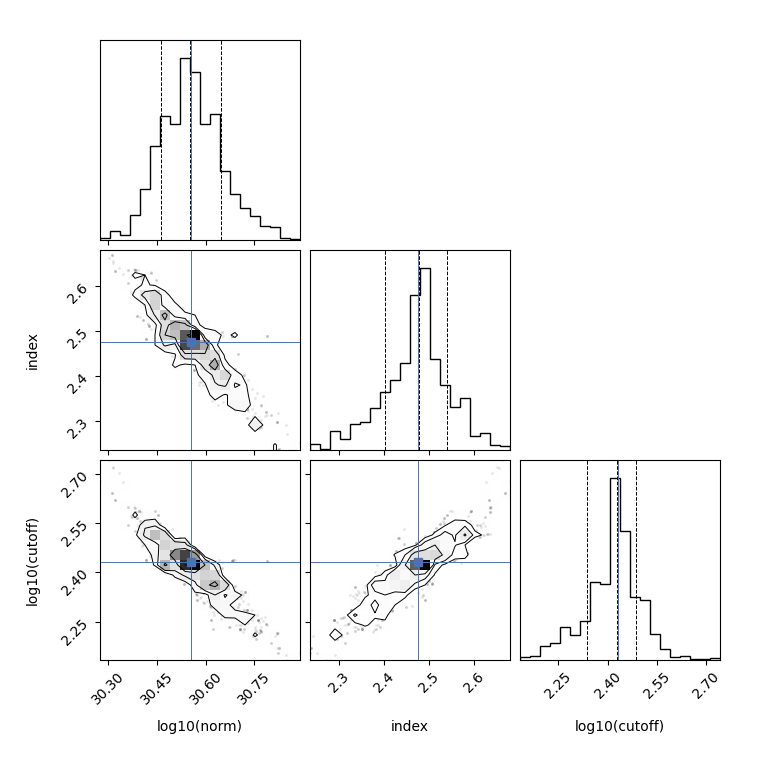

In [77]:
Image("RSOph_results/hadronic_model/fit_naima_results_all_day1_corner.png")


Do the dependencies between the different parameters make sense? Are they correlated?

Check the model output

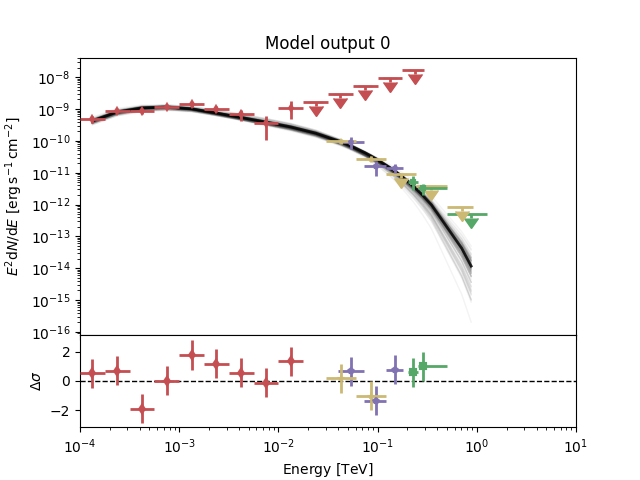

In [78]:
Image("RSOph_results/hadronic_model/fit_naima_results_all_day1_model0.png")

However, these are diagnostic plots. The are not usually used in papers they are for diagnostics.

Now we want to plot produce ourself the latest plot: display the best-fit model with the SED data.

Fistly, we have to use the best-fit particle energy distribution. Secondly, create the radiative model.

In [91]:
#Day 1
particle_distribution_day1 = naima.models.ExponentialCutoffPowerLaw(
    tabs_hadronic[0]["median"][1]*u.Unit('1/eV'), 
    130.0 * u.GeV, 
    tabs_hadronic[0]["median"][2], 
    tabs_hadronic[0]["median"][4]*u.GeV
)
radiative_model_day1 = naima.models.PionDecay(
    particle_distribution_day1, nh=6.0e8*(1/3)**(-3) * u.cm ** -3
)

#Day 2
particle_distribution_day2 = naima.models.ExponentialCutoffPowerLaw(
    tabs_hadronic[1]["median"][1]*u.Unit('1/eV'), 
    130.0 * u.GeV, 
    tabs_hadronic[1]["median"][2], 
    tabs_hadronic[1]["median"][4]*u.GeV
)
radiative_model_day2 = naima.models.PionDecay(
    particle_distribution_day2, nh=6.0e8*(2/3)**(-3) * u.cm ** -3
)

#Day 3
particle_distribution_day3 = naima.models.ExponentialCutoffPowerLaw(
    tabs_hadronic[2]["median"][1]*u.Unit('1/eV'), 
    130.0 * u.GeV, 
    tabs_hadronic[2]["median"][2], 
    tabs_hadronic[2]["median"][4]*u.GeV
)
radiative_model_day3 = naima.models.PionDecay(
    particle_distribution_day3, nh=6.0e8*(3/3)**(-3) * u.cm ** -3
)

#Day 4
particle_distribution_day4 = naima.models.ExponentialCutoffPowerLaw(
    tabs_hadronic[3]["median"][1]*u.Unit('1/eV'), 
    130.0 * u.GeV, 
    tabs_hadronic[3]["median"][2], 
    tabs_hadronic[3]["median"][4]*u.GeV
)
radiative_model_day4 = naima.models.PionDecay(
    particle_distribution_day4, nh=6.0e8*(4/3)**(-3) * u.cm ** -3
)

We are ready to show the results

In [92]:
from RSOph_results.hadronic_model.RSOph_hadronic import PionDecayModel

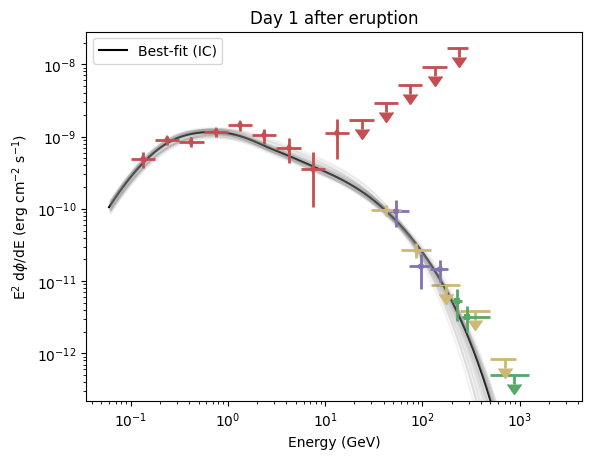

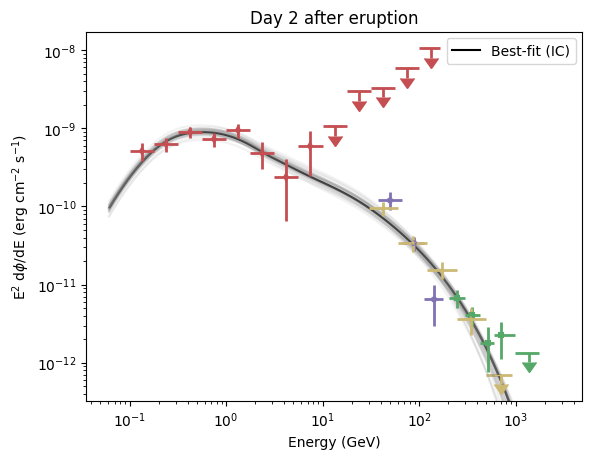

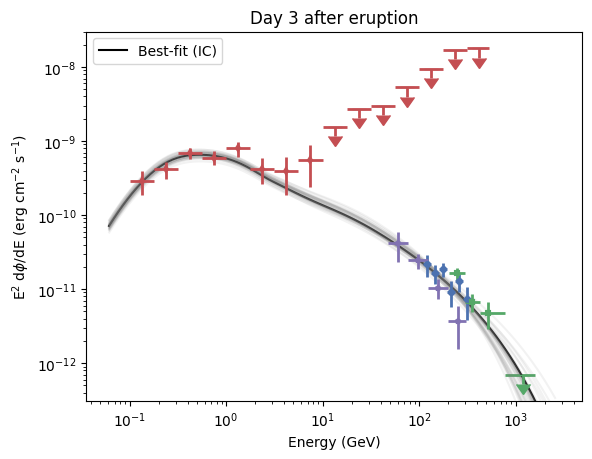

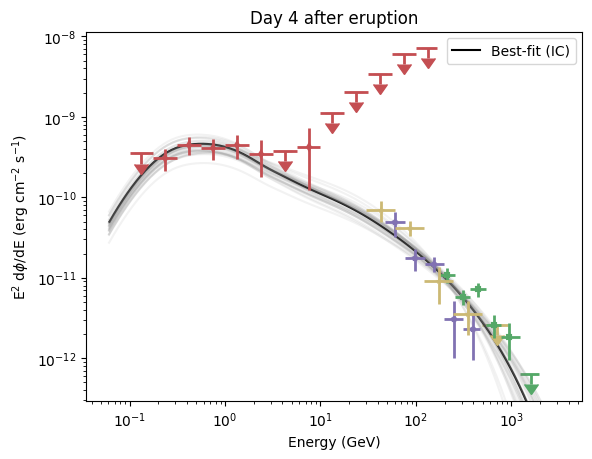

In [93]:
photon_energy=np.geomspace(0.00006, 2.6,100)*u.TeV

with quantity_support():
    for ii,(day,data,rad_model) in enumerate(zip(
        [1,2,3,4],
        daily_data,
        [radiative_model_day1,radiative_model_day2,radiative_model_day3,radiative_model_day4]
    )):

        fig=naima.plot_data(data, e_unit=u.GeV)
        ax = fig.axes[0]
        ax.set_title(f"Day {day} after eruption")

        ax.xaxis.units = u.GeV
        ax.yaxis.units = u.Unit("erg s-1 cm-2")
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()

        plt.loglog(
            photon_energy,
            rad_model.sed(photon_energy,distance=2.45 * u.kpc),
            color="k",
            label=r"Best-fit (IC)"
        )

        PionDecay_func=PionDecayModel(day)
        for i in range(min(np.shape(runs_hardonic[ii].get_chain())[1],100)):            
            photon_energy=np.geomspace(xmin,xmax,100)*u.GeV
            flux=PionDecay_func.PionDecay(runs_hardonic[ii].get_chain()[-1,i,:],data=photon_energy)
            # SED := E**2 * differential flux (d\phi/dE)
            plt.loglog(photon_energy,photon_energy**2*flux,color="gray",alpha=0.1)

        ax.set_ylim((ymin, ymax))
        ax.set_ylabel(f"E$^2$ d$\phi$/dE (erg cm$^{{-2}}$ s$^{{-1}}$)")
        ax.set_xlabel(f"Energy (GeV)")    
        ax.legend()

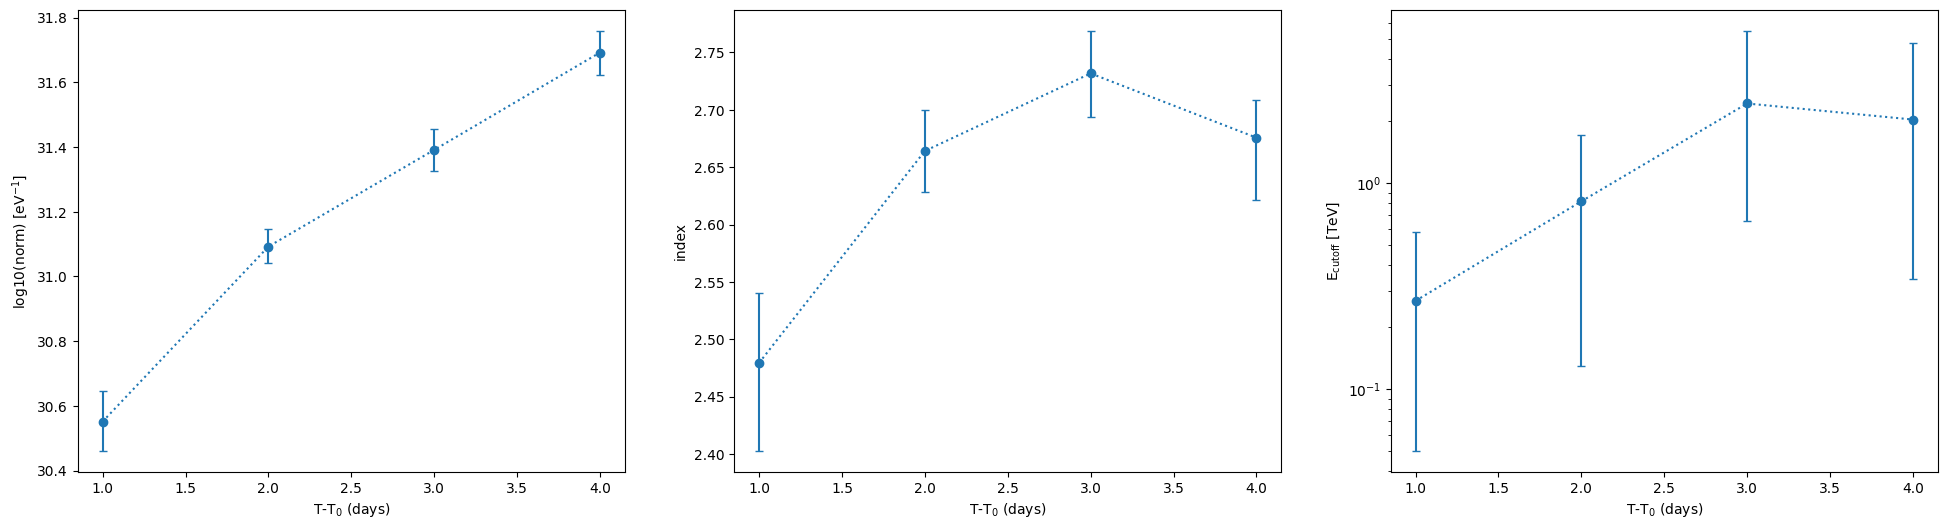

In [ ]:
# Plot the evolution of the parameters
tabs_val=[]
tabs_err_lo=[]
tabs_err_hi=[]
labels=["log10(norm)","index","log10(cutoff)"]

for tab in tabs_hadronic:
    tab_val=[]
    tab_err_lo=[]
    tab_err_hi=[]    
    for i in range(len(tab)):
        if tab["label"][i] in labels:
            tab_val.append(tab["median"][i])
            tab_err_lo.append(tab["unc_lo"][i])
            tab_err_hi.append(tab["unc_hi"][i])
            
    tabs_val.append(tab_val)
    tabs_err_lo.append(tab_err_lo)
    tabs_err_hi.append(tab_err_hi)

tabs_val=np.array(tabs_val)
tabs_err_lo=np.array(tabs_err_lo)
tabs_err_hi=np.array(tabs_err_hi)   
    
fig,axs=plt.subplots(1,3,figsize=(8*3,6))
axs[0].errorbar(
    x=[1,2,3,4],y=tabs_val[:,0],
    yerr=[tabs_err_lo[:,0],tabs_err_hi[:,0]],
    ls=":",capsize=3,marker="o"
)
axs[0].set_ylabel(fr"{labels[0]} [eV$^{{-1}}$]")
axs[0].set_xlabel(r"T-T$_0$ (days)")

axs[1].errorbar(
    x=[1,2,3,4],y=tabs_val[:,1],
    yerr=[tabs_err_lo[:,1],tabs_err_hi[:,1]],
    ls=":",capsize=3,marker="o"
)
axs[1].set_ylabel(labels[1])
axs[1].set_xlabel(r"T-T$_0$ (days)")

axs[2].errorbar(
    x=[1,2,3,4],y=10**tabs_val[:,2]/1000,
    yerr=[10**(tabs_val[:,2]-tabs_err_lo[:,2])/1000,10**(tabs_val[:,2]+tabs_err_hi[:,2])/1000],
    ls=":",capsize=3,marker="o"
)
axs[2].set_ylabel(fr"E$_{{\rm cutoff}}$ [TeV]")
axs[2].set_yscale(r"log");
# axs[2].set_ylabel(fr"log$_{{10}}$(E$_{{\rm cutoff}}$) [GeV]")
axs[2].set_xlabel(r"T-T$_0$ (days)");

Text(0, 0.5, 'dNp/dE (eV-1)')

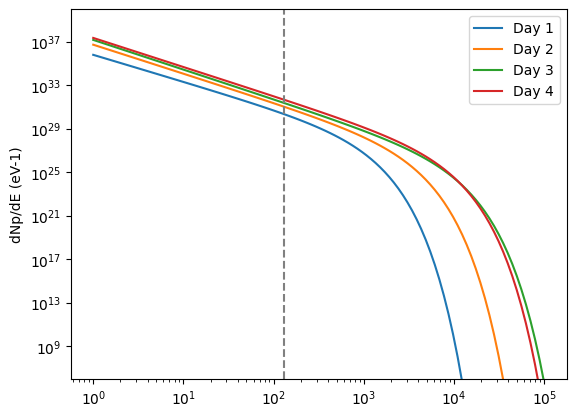

In [107]:
energ=np.geomspace(1,1e5,100)*u.GeV
plt.loglog(
    energ,
    particle_distribution_day1._calc(energ),
    label="Day 1",
)
plt.loglog(
    energ,
    particle_distribution_day2._calc(energ),
    label="Day 2"
)
plt.loglog(
    energ,
    particle_distribution_day3._calc(energ),
    label="Day 3"
)
plt.loglog(
    energ,
    particle_distribution_day4._calc(energ),
    label="Day 4"
)
plt.legend()
plt.vlines(130,1e6,1e40,ls="--",color="gray")
plt.ylim((1e6,1e40))
plt.ylabel("Energy (GeV)")
plt.ylabel("dNp/dE (eV-1)")

# Leptonic model

In this case we use electrons to explain the gamma-ray emission. In this case, we will use the inverse Compton scattering.

In [83]:
%%writefile RSOph_results/leptonic_model/RSOph_leptonic.py

import astropy.units as u
import numpy as np
from astropy.io import ascii
from astropy.table import vstack
import naima
from naima.models import ExponentialCutoffPowerLaw, InverseCompton
import os
from astropy.table import Table

class ICmodel:
    """
    Define a model for the IC emission from a electron distribution
    following a power-law with exponential cut-off.
    
    A variable photon energy density and characteristic photon temperature. 
    The former is parameterized as a function of the day after the nova explosion.
    """
    def __init__(self, day_value):
        assert day_value in [1,2,3,4]
        self.day_value = day_value
        Temp_value_array = [10780,9500,8460,7680]
        self.Temp_value = Temp_value_array[self.day_value-1]

    def IC(self, pars, data):
        """
        Define particle distribution model, radiative model, and return model flux
        at data energy values
        """
        amplitude = 10**pars[0] / u.eV
        alpha = pars[1]
        e_cutoff = (10 ** pars[2]) * u.GeV

        ECPL = ExponentialCutoffPowerLaw(amplitude, 130 * u.GeV, alpha, e_cutoff)
        IC = InverseCompton(
            ECPL,
            seed_photon_fields=[
                "CMB",
                ["photosphere", 
                self.Temp_value*u.K, 
                0.14*((self.Temp_value/8460)**4/(self.day_value/3)**2)*u.Unit("erg cm-3")]
            ],
        )
        return IC.flux(data, distance=2.45 * u.kpc)


def lnprior(pars):
    # Limit amplitude to positive domain
    logprob = naima.uniform_prior(pars[0], 0, np.inf)
            
    return logprob

if __name__ == '__main__':

    ## Set initial parameters and labels    
    labels = ["log10(norm)", "index", "log10(cutoff)"]
    day_array=[1,2,3,4]

    sed_day1 = Table.read('../data/RSOph/RSOph_day1_sed.ecsv',format='ascii.ecsv')
    sed_day2 = Table.read('../data/RSOph/RSOph_day2_sed.ecsv',format='ascii.ecsv')
    sed_day3 = Table.read('../data/RSOph/RSOph_day3_sed.ecsv',format='ascii.ecsv')
    sed_day4 = Table.read('../data/RSOph/RSOph_day4_sed.ecsv',format='ascii.ecsv')

    daily_data = [sed_day1, sed_day2, sed_day3, sed_day4]

    os.system("rm RSOph_results/leptonic_model/fit_naima_results_all*")

    for yy,iday in enumerate(day_array):
        
        p0 = np.array((27, 2.5, np.log10(200)))
        day_value=iday
        IC_func=ICmodel(day_value)

        print("day",day_value)

        # Run sampler    
        sampler, pos = naima.run_sampler(
            data_table=daily_data[yy],
            p0=p0,
            labels=labels,
            model=IC_func.IC,
            prior=lnprior,
            nwalkers=50,
            nburn=50,
            nrun=40,
            # threads=4,
            prefit=True, # needed to start in good initial parameters
            interactive=True, #adjust p0 interatively with pop-up window (it only works from command line)
        );
        ## Save run results
        out_root = "RSOph_results/leptonic_model/fit_naima_results_all_day{}".format(day_array[yy])
        naima.save_run(out_root + ".hdf5", sampler)

        ## Save diagnostic plots and results table
        naima.save_diagnostic_plots(out_root, sampler, sed=True)
        naima.save_results_table(out_root, sampler) 
        print( )
        print( )

Overwriting RSOph_results/leptonic_model/RSOph_leptonic.py


In [84]:
subprocess.run(["python","RSOph_results/leptonic_model/RSOph_leptonic.py"])

day 1
INFO: Launching interactive model fitter, close when finished [naima.core]


Figure(640x480)
INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [28.35270949  2.5         2.30103   ] [naima.core]
INFO:    Initial lnprob(p0): -13766.914 [naima.core]
INFO:    New ML parameters : [27.40187204  2.9310723   2.0501191 ] [naima.core]
INFO:    Maximum lnprob(p0): -21.255 [naima.core]
Burning in the 50 walkers with 50 steps...

Progress of the run: 0 percent (0 of 50 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      27.4            2.93            2.05      
  Last ensemble std    :      0.119           0.016          0.0104     
  Last ensemble lnprob :  avg: -37.571, max: -21.228

Progress of the run: 10 percent (5 of 50 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      27.4            2.93            2.05      
  Last ensemble std    :     0.0868          0.0286          0.0162    

/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/site-packages/naima/analysis.py:163: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  f.clf()


INFO: Plotting Model output 1... [naima.analysis]
INFO: Saving results table in RSOph_results/leptonic_model/fit_naima_results_all_day1_results.ecsv [naima.analysis]


day 2
INFO: Launching interactive model fitter, close when finished [naima.core]
Figure(640x480)
INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [29.08082583  2.5         2.30103   ] [naima.core]
INFO:    Initial lnprob(p0): -13186.494 [naima.core]
INFO:    New ML parameters : [27.82032112  3.14182655  2.54164798] [naima.core]
INFO:    Maximum lnprob(p0): -17.208 [naima.core]
Burning in the 50 walkers with 50 steps...

Progress of the run: 0 percent (0 of 50 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      27.8            3.15            2.54      
  Last ensemble std    :     0.0943          0.0154          0.0136     
  Last ensemble lnprob :  avg: -23.738, max: -17.290

Progress of the ru

/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/site-packages/naima/analysis.py:163: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  f.clf()


INFO: Plotting Model output 1... [naima.analysis]
INFO: Saving results table in RSOph_results/leptonic_model/fit_naima_results_all_day2_results.ecsv [naima.analysis]


day 3
INFO: Launching interactive model fitter, close when finished [naima.core]
Figure(640x480)
INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [29.74026449  2.5         2.30103   ] [naima.core]
INFO:    Initial lnprob(p0): -26693.945 [naima.core]
INFO:    New ML parameters : [28.15434228  3.1733362   3.03653082] [naima.core]
INFO:    Maximum lnprob(p0): -21.004 [naima.core]
Burning in the 50 walkers with 50 steps...

Progress of the run: 0 percent (0 of 50 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      28.1            3.17            3.04      
  Last ensemble std    :      0.123           0.019          0.0172     
  Last ensemble lnprob :  avg: -29.466, max: -21.013

Progress of the ru

/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/site-packages/naima/analysis.py:163: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  f.clf()


INFO: Plotting Model output 1... [naima.analysis]
INFO: Saving results table in RSOph_results/leptonic_model/fit_naima_results_all_day3_results.ecsv [naima.analysis]


day 4
INFO: Launching interactive model fitter, close when finished [naima.core]
Figure(640x480)
INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [29.87531616  2.5         2.30103   ] [naima.core]
INFO:    Initial lnprob(p0): -9178.748 [naima.core]
INFO:    New ML parameters : [28.42940772  3.1519856   3.16743865] [naima.core]
INFO:    Maximum lnprob(p0): -16.001 [naima.core]
Burning in the 50 walkers with 50 steps...

Progress of the run: 0 percent (0 of 50 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      28.4            3.16            3.17      
  Last ensemble std    :      0.126          0.0177          0.0124     
  Last ensemble lnprob :  avg: -27.685, max: -16.332

Progress of the run

/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/site-packages/naima/analysis.py:163: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  f.clf()
Exception ignored in: <function Pool.__del__ at 0x12f93f6a0>
Traceback (most recent call last):
  File "/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/multiprocessing/pool.py", line 271, in __del__
  File "/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/multiprocessing/queues.py", line 371, in put
AttributeError: 'NoneType' object has no attribute 'dumps'


INFO: Plotting Model output 1... [naima.analysis]
INFO: Saving results table in RSOph_results/leptonic_model/fit_naima_results_all_day4_results.ecsv [naima.analysis]




CompletedProcess(args=['python', 'RSOph_results/leptonic_model/RSOph_leptonic.py'], returncode=0)

We do the same steps as in the hadronic case to access the results and show the gamma-ray emission of the best-fit model

In [85]:
tabs_leptonic=[]
for day in [1,2,3,4]:
    tab=Table.read(f"RSOph_results/leptonic_model/fit_naima_results_all_day{day}_results.ecsv")
    tabs_leptonic.append(tab) 


In [86]:
display(tabs_leptonic[0])

label,median,unc_lo,unc_hi
str13,float64,float64,float64
log10(norm),27.823622936454036,0.2185552509490165,0.30617559597337163
norm,6.662280848895616e+27,2.634481897614591e+27,6.821091640330646e+27
index,2.6626451600875223,0.19795280584490005,0.1486814418869944
log10(cutoff),1.7525523510259464,0.14563017079125173,0.16260972781820127
cutoff,56.56559433679308,16.11525397670777,25.6893627939928
blob1,nan,nan,nan


In [87]:
Temp_value_array=[10780,9500,8460,7680]
runs_leptonic=[]
for day in [1,2,3,4]:
    file=f"RSOph_results/leptonic_model/fit_naima_results_all_day{day}.hdf5"
    run=naima.read_run(file, modelfn=None)
    runs_leptonic.append(run)
# naima.plot_corner(runs_leptonic[0]);
# naima.plot_chain(runs_leptonic[0],0);

In [88]:
#Day 1
particle_distribution_day1 = naima.models.ExponentialCutoffPowerLaw(
    tabs_leptonic[0]["median"][1]*u.Unit('1/eV'), 
    130.0 * u.GeV, 
    tabs_leptonic[0]["median"][2], 
    tabs_leptonic[0]["median"][4]*u.GeV
)
radiative_model_day1 = naima.models.InverseCompton(
    particle_distribution_day1, 
    seed_photon_fields=[
        "CMB",
        ["photosphere",10780*u.K,0.14*((10780/8460)**4/(1/3)**2)*u.Unit("erg cm-3")]
    ]
)

#Day 2
particle_distribution_day2 = naima.models.ExponentialCutoffPowerLaw(
    tabs_leptonic[1]["median"][1]*u.Unit('1/eV'), 
    130.0 * u.GeV, 
    tabs_leptonic[1]["median"][2], 
    tabs_leptonic[1]["median"][4]*u.GeV
)
radiative_model_day2 = naima.models.InverseCompton(
    particle_distribution_day2, 
    seed_photon_fields=[
        "CMB",
        ["photosphere",9500*u.K,0.14*((9500/8460)**4/(2/3)**2)*u.Unit("erg cm-3")]
    ]
)

#Day 3
particle_distribution_day3 = naima.models.ExponentialCutoffPowerLaw(
    tabs_leptonic[2]["median"][1]*u.Unit('1/eV'), 
    130.0 * u.GeV, 
    tabs_leptonic[2]["median"][2], 
    tabs_leptonic[2]["median"][4]*u.GeV
)
radiative_model_day3 = naima.models.InverseCompton(
    particle_distribution_day3, 
    seed_photon_fields=[
        "CMB",
        ["photosphere",8460*u.K,0.14*((8460/8460)**4/(3/3)**2)*u.Unit("erg cm-3")]
    ]
)

#Day 4
particle_distribution_day4 = naima.models.ExponentialCutoffPowerLaw(
    tabs_leptonic[3]["median"][1]*u.Unit('1/eV'), 
    130.0 * u.GeV, 
    tabs_leptonic[3]["median"][2], 
    tabs_leptonic[3]["median"][4]*u.GeV
)
radiative_model_day4 = naima.models.InverseCompton(
    particle_distribution_day4, 
    seed_photon_fields=[
        "CMB",
        ["photosphere",7680*u.K,0.14*((7680/8460)**4/(4/3)**2)*u.Unit("erg cm-3")]
    ]
)

In [89]:
from RSOph_results.leptonic_model.RSOph_leptonic import ICmodel

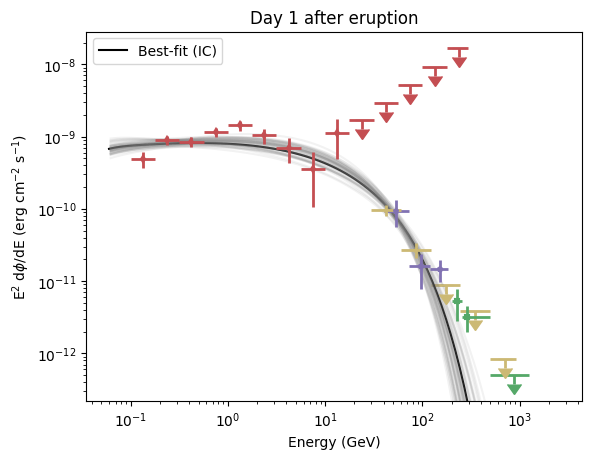

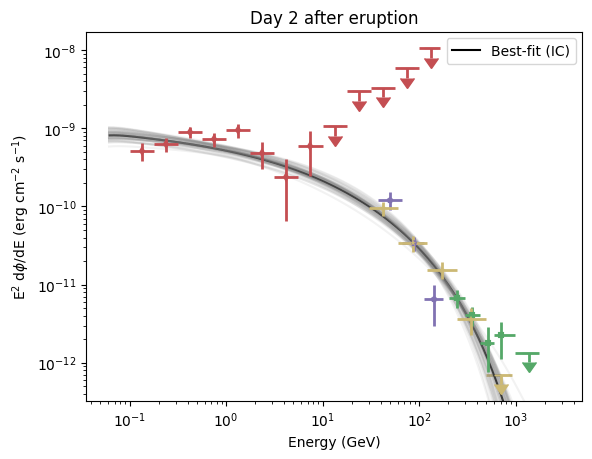

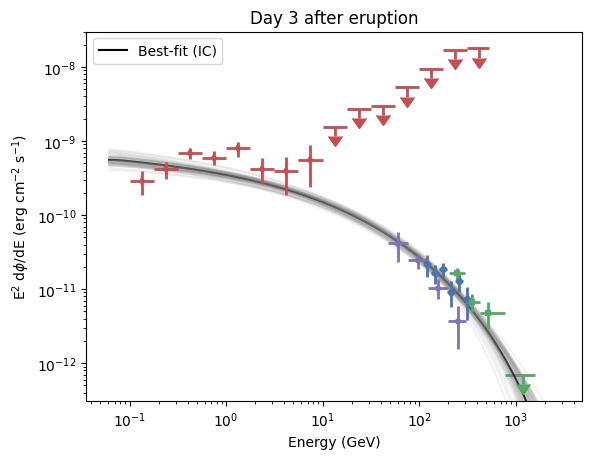

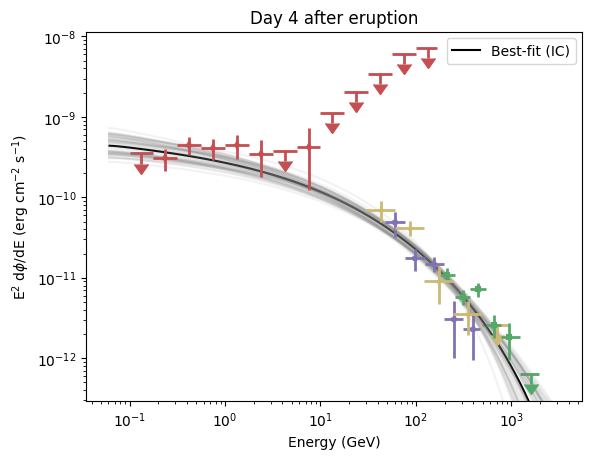

In [90]:
photon_energy=np.geomspace(0.00006, 2.6,100)*u.TeV

with quantity_support():
    for ii,(day,data,rad_model) in enumerate(zip(
        [1,2,3,4],
        daily_data,
        [radiative_model_day1,radiative_model_day2,radiative_model_day3,radiative_model_day4]
    )):

        fig=naima.plot_data(data, e_unit=u.GeV)
        ax = fig.axes[0]
        ax.set_title(f"Day {day} after eruption")

        ax.xaxis.units = u.GeV
        ax.yaxis.units = u.Unit("erg s-1 cm-2")
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        
        plt.loglog(
            photon_energy,
            rad_model.sed(photon_energy,distance=2.45 * u.kpc),
            color="k",
            label=r"Best-fit (IC)"
        )

        IC_func=ICmodel(day)
        for i in range(min(np.shape(runs_leptonic[ii].get_chain())[1],100)):            
            photon_energy=np.geomspace(xmin,xmax,100)*u.GeV
            flux=IC_func.IC(runs_leptonic[ii].get_chain()[-1,i,:],data=photon_energy)
            # SED := E**2 * differential flux (d\phi/dE)
            plt.loglog(photon_energy,photon_energy**2*flux,color="gray",alpha=0.1)

        ax.set_ylim((ymin, ymax))
        ax.set_ylabel(f"E$^2$ d$\phi$/dE (erg cm$^{{-2}}$ s$^{{-1}}$)")
        ax.set_xlabel(f"Energy (GeV)")    
        ax.legend()